In [1]:
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.ndimage
import neurokit2 as nk
import pandas as pd
from scipy.signal import iirnotch, lfilter, butter
import scipy
from scipy.fft import fft
from scipy.signal import find_peaks, peak_prominences
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline


dataset_path= "electrocardiogram-skin-conductance-and-respiration-from-spider-fearful-individuals-watching-spider-video-clips-1.0.0"

sampling_rate = 100

In [50]:
# to get the list of directories in the specified directory.
onlydirs = [f for f in listdir(dataset_path) if isdir(join(dataset_path, f))]
#print(onlydirs)
print(len(onlydirs))

#subject's folder in the list
#sub_ind = 14
print("Looking at patient: ", onlydirs[3])

# read triggers file
csvpath = dataset_path+'/'+onlydirs[3]+'/Triggers.txt'
info = np.loadtxt(csvpath,dtype='str')
print(len(info))
print(info)

57
Looking at patient:  VP69
20
[['BIOFEEDBACK-HRV-TRAININGS' '203' '203']
 ['CLIP-DEMO' '141627' '141737']
 ['CLIP-3' '141757' '141858']
 ['CLIP-4' '141922' '142022']
 ['CLIP-2' '142039' '142139']
 ['CLIP-1' '142200' '142300']
 ['CLIP-7' '142401' '142501']
 ['CLIP-8' '142517' '142618']
 ['CLIP-6' '142632' '142732']
 ['CLIP-5' '142754' '142855']
 ['CLIP-10' '143102' '143202']
 ['CLIP-12' '143226' '143327']
 ['CLIP-9' '143403' '143504']
 ['CLIP-11' '143632' '143733']
 ['CLIP-13' '143833' '143933']
 ['CLIP-14' '144015' '144115']
 ['CLIP-16' '144140' '144241']
 ['CLIP-15' '144256' '144356']
 ['BIOFEEDBACK-OXYGEN-TRAININGS' '141459' '144422']
 ['BIOFEEDBACK-REST' '144608' '145108']]


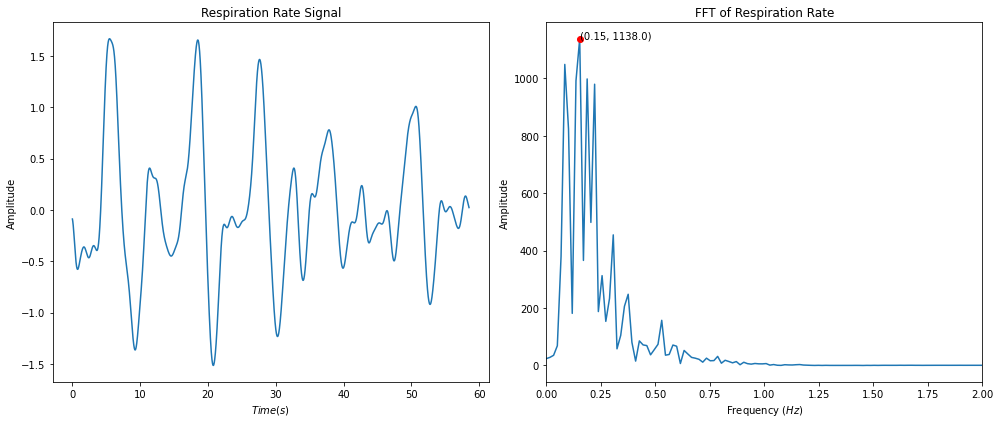

9.230769230769232

In [80]:
def RR_data(sub_ind):
    # read prespiration file
    csvpath = dataset_path+'/'+onlydirs[sub_ind]+'/BitalinoBR.txt'
    # load the txt file
    data = np.loadtxt(csvpath,dtype='str')

    # respiratory recording
    RR = data[:,0].astype(float)
    # timestamps
    RR_time = data[:,1].astype(float)

    return RR, RR_time



###### Display correct section of Respiration Rate Data


def clip_range(sub_ind, clip_number, RR_time):
    #clip to be displayed
    min_time = float(info[clip_number][1])
    max_time = float(info[clip_number][2])
    

    min_index = 0.0
    max_index = 0.0
    for i in range(len(RR_time)):
        if(float(RR_time[i]) < min_time):
            min_index = i

        if(float(RR_time[i]) < max_time):
            max_index = i

    #print(info[clip_number][0])

    return min_index, max_index


def calc_respiration_rate(sub_ind,clip_number):

    #Fetch data
    RR, RR_time = RR_data(sub_ind)

    #Specify range of clips
    min_index, max_index = clip_range(sub_ind, clip_number, RR_time)
    


    RR = RR[min_index:max_index]
    t = np.arange(0,RR.size*0.01,0.01)
    t = t[:RR.size]

    RR = (RR- np.mean(RR))/np.std(RR)

    ############ Signal filtering in order to make it smooth
    Fs = sampling_rate 
    order = 4 
    frequency = 45
    frequency = frequency/(Fs/2)
    b, a = scipy.signal.butter(order, frequency, btype='low')
    RR_lp = scipy.signal.filtfilt(b, a, RR)


    size= int(0.75*Fs)
    RR_sm0 = scipy.ndimage.uniform_filter1d(RR_lp, int(size), mode='nearest') 

    kernel="parzen"
    window = scipy.signal.get_window(kernel, 150) 
    w = window / window.sum()

    firstvalue = np.repeat(RR_sm0[0], 50)
    lastvalue = np.repeat(RR_sm0[-1], 100)
    eda_sm0 = np.concatenate((firstvalue, RR_sm0, lastvalue))

    RR_sm = np.convolve(w, RR_sm0, mode='same')
    RR_sm = RR_sm[size:-size]


    ## High Pass filter to remove the unwanted low frequencies below 0.05 Hz which result in a breathing rate of 3 Breaths per minute
    ## Minimum number of breaths are 12 breaths per minute (https://www.healthline.com/health/normal-respiratory-rate#normal-rate-in-kids)
    ## 10 breaths per minute = 0.17 Hz
    order=2
    freqs=[0.09]
    sos = scipy.signal.butter(order, freqs, btype='high', output="sos", fs= Fs)
    RR_sm= scipy.signal.sosfiltfilt(sos, RR_sm)

    #Find Respiration Rate through FFT
    Y = np.abs(fft(RR_sm))
    F = np.arange(0,sampling_rate,sampling_rate/np.size(Y))
    F = F[:len(Y)]

    RR = F[np.argmax(Y)]*60
    #print('Respiration Rate:',RR)


    ####### Plot Signal

    t = t[:len(RR_sm)]
    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.plot(t,RR_sm)
    plt.xlabel('$Time (s)$') 
    plt.ylabel('Amplitude') 
    plt.title('Respiration Rate Signal')

    plt.subplot(1,2,2)
    plt.plot(F,Y)
    plt.plot(F[np.argmax(Y)], Y[np.argmax(Y)], 'o', color = "red")
    plt.text(F[np.argmax(Y)], Y[np.argmax(Y)], '({}, {})'.format( round(F[np.argmax(Y)],2), round(Y[np.argmax(Y)],0)))
    plt.xlabel("Frequency $(Hz)$")
    plt.ylabel("Amplitude")
    plt.title("FFT of Respiration Rate")
    plt.xlim([0,2])

    plt.tight_layout()
    plt.savefig('true RR.png')

    plt.show()

    return RR


calc_respiration_rate(3,6)



array([ 0.00293523,  0.01436106,  0.02513967, ..., -0.05652875,
       -0.01262644,  0.02254367])

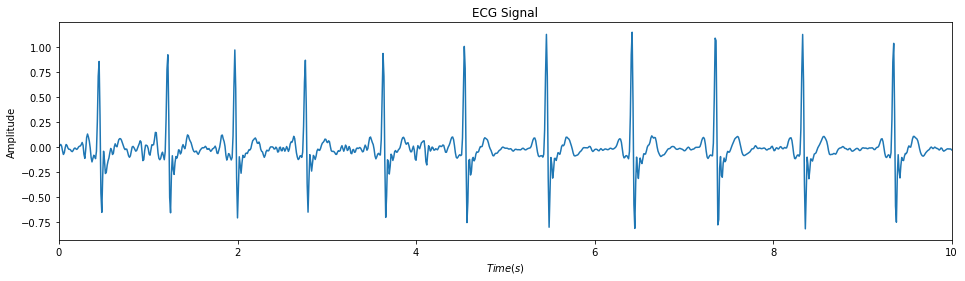

In [88]:
def generate_ecg(sub_ind, clip_number):

    # read ecg file
    csvpath = dataset_path+'/'+onlydirs[sub_ind]+'/BitalinoECG.txt'
    # load the txt file
    data = np.loadtxt(csvpath,dtype='str')
    # ecg recording
    ecg = data[:,0].astype(float)
    # timestamps
    ecg_time = data[:,1].astype(float)


    RR, RR_time = RR_data(sub_ind)

    min_index, max_index = clip_range(sub_ind, clip_number, RR_time)

    ecg = ecg[min_index:max_index]
    t=np.arange(0,ecg.size*0.01,0.01)
    t=t[:ecg.size]

    ## Notch filter to remove 40 - 50 Hz from the mains
    nyq = 0.5*sampling_rate
    notch=50
    notch = notch/nyq
    b, a = iirnotch(notch, 30, fs=sampling_rate)
    ecg = lfilter(b,a,ecg)

    # lowpass filter
    low= 1250 #1250 is a good value
    low= low/nyq
    b, a = butter(5, low, fs = sampling_rate)
    ecg = lfilter(b,a,ecg)

    t = t[:len(ecg)]
    plt.figure(figsize=(16,4))
    plt.plot(t,ecg)
    
    plt.xlabel('$Time (s)$') 
    plt.ylabel('Amplitude') 
    plt.title('ECG Signal')
    plt.xlim([0,10])

    return ecg



generate_ecg(3,6)

Baseline Wandering RR: 31.249999999999996


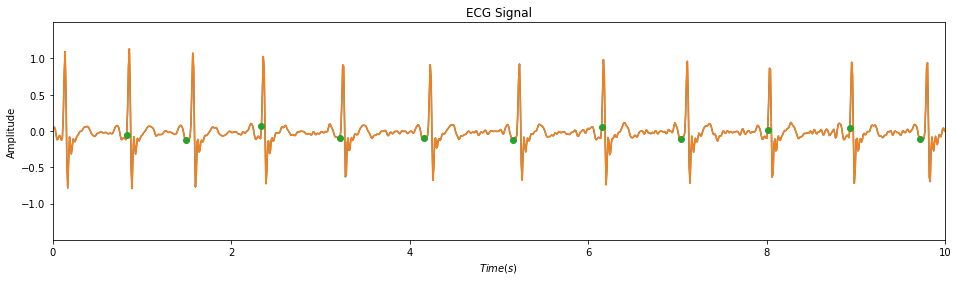

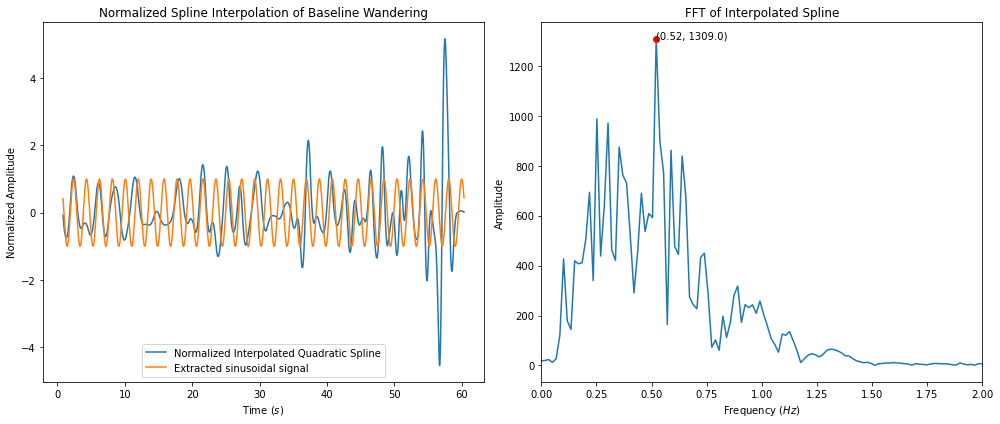

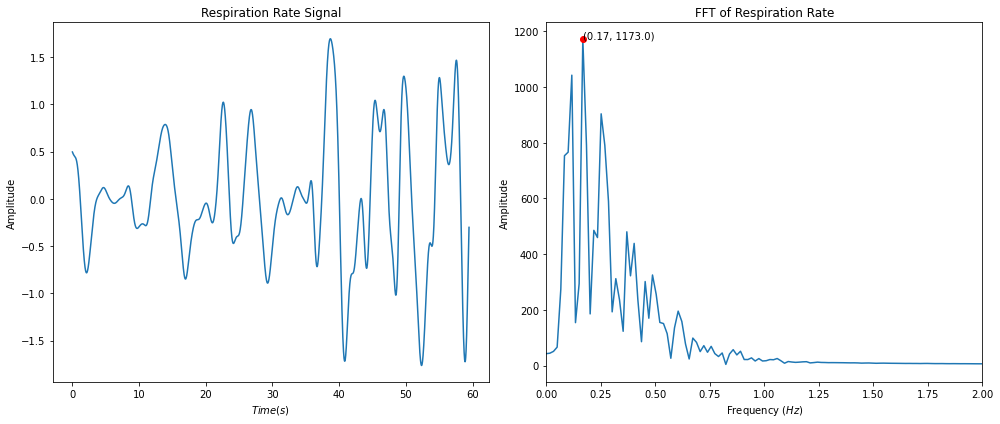

10.087424344317418

In [89]:
def generate_bw(sub_ind, clip_number):

    ecg = generate_ecg(sub_ind, clip_number)

    _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=100)

    signal_dwt, waves_dwt = nk.ecg_delineate(ecg, 
                                          rpeaks, 
                                          sampling_rate=100, 
                                           method="cwt", 
                                 show_type='peaks')


    ## Focus on ECG P Offsets from the library of available points (https://neuropsychology.github.io/NeuroKit/examples/ecg_delineate/ecg_delineate.html)
    ## Quadratic Spline Interpolation for Baseline Wandering

    t=np.arange(0,ecg.size*(1/sampling_rate),(1/sampling_rate))
    t=t[:ecg.size]

    points = waves_dwt["ECG_Q_Peaks"]

    ## Remove nan values
    points = [x for x in points if str(x) != 'nan']

    ##Plot ECG data
    plt.plot(t,ecg, label = "ECG Signal")
    plt.plot(t[points],ecg[points],'o', label = "Q Peak Points")
    plt.xlim([0,10])

    #Interpolate points
    cs = interp1d(t[points], ecg[points], kind = 'quadratic', fill_value="extrapolate")
    interpolated = np.arange(t[np.min(points)], t[np.max(points)], 0.01)
    spline_bw = cs(interpolated)


    #Normalize points
    spline_bw_norm = (spline_bw- np.mean(spline_bw))/np.std(spline_bw)

    #rqi_bw = rqi_calc(spline_bw_norm)

    #High pass filter to remove anything below 0.09 Hz. Baseline wandering is around 0.5 - 0.6 Hz
    order=2
    freqs=[0.1]
    sos = scipy.signal.butter(order, freqs, btype='high', output="sos", fs= sampling_rate)
    spline_bw_norm= scipy.signal.sosfiltfilt(sos, spline_bw_norm)



    Y = np.abs(fft(spline_bw_norm))
    F = np.arange(0,sampling_rate,sampling_rate/np.size(Y))
    F = F[:len(Y)]

    RR_bw = F[np.argmax(Y)] * 60
    print('Baseline Wandering RR:', RR_bw)

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(interpolated,spline_bw_norm, label = "Normalized Interpolated Quadratic Spline")
    plt.plot(interpolated, np.sin(2*np.pi*F[np.argmax(Y)]*interpolated), label = "Extracted sinusoidal signal")

    plt.xlabel("Time $(s)$")
    plt.ylabel("Normalized Amplitude")
    plt.title("Normalized Spline Interpolation of Baseline Wandering")
    plt.legend(loc = "lower center")
    plt.savefig("BW interpolation.png")

    plt.subplot(1,2,2)
    plt.plot(F,Y)
    plt.plot(F[np.argmax(Y)], Y[np.argmax(Y)], 'o', color = "red")
    plt.text(F[np.argmax(Y)], Y[np.argmax(Y)], '({}, {})'.format( round(F[np.argmax(Y)],2), round(Y[np.argmax(Y)],0)))
    plt.xlabel("Frequency $(Hz)$")
    plt.ylabel("Amplitude")
    plt.title("FFT of Interpolated Spline")
    plt.xlim([0,2])

    plt.tight_layout()
    plt.savefig('BW signal.png')
    plt.show()



    return RR_bw
    #rqi_bw


#Call Function
## Calculate Respiration Rate


generate_bw(3, 12)
calc_respiration_rate(3,12)


In [13]:


def rqi_calc(function):

    peaks, _ = find_peaks(function)
    troughs, _ = find_peaks(-function)
    peak_prominence = peak_prominences(function, peaks)[0]
    trough_prominence = peak_prominences(-function, troughs)[0]

    contour_heights = function[peaks] - peak_prominence
    contour_depths = trough_prominence + function[troughs]



    peak_peak = np.asarray([], dtype = "float")

    for i in range(1,len(peaks)):
        peak_peak = np.append(peak_peak, (peaks[i] - peaks[i-1])/sampling_rate)

    trough_trough = np.asarray([], dtype = "float")

    for i in range(1,len(troughs)):
        trough_trough = np.append(trough_trough, (troughs[i] - troughs[i-1])/sampling_rate)

        dcv_ph = 1 - (np.std(contour_heights)/np.mean(contour_heights))
        dcv_td =  1 - (np.std(contour_depths)/np.mean(contour_depths))
        dcv_pp =  1 - (np.std(peak_peak)/np.mean(peak_peak))
        dcv_tt =  1 - (np.std(trough_trough)/np.mean(trough_trough))



    #plt.plot(peaks, function[peaks], "x")
    #plt.vlines(x=peaks, ymin=contour_heights, ymax=function[peaks], color = 'blue')
    #plt.vlines(x=troughs, ymin=function[troughs], ymax= contour_depths, color = 'red')
    #plt.plot(function)
    #plt.plot(troughs, function[troughs], "o")
    #plt.xlim([0,2000])

    RQI = max((dcv_ph + dcv_td + dcv_pp + dcv_tt)/4,0)

    return RQI